In [20]:
%matplotlib inline
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, f1_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [97]:
from sklearn.utils import resample

In [83]:
skip=['PIG-UPMC-pig55-T0-hgomez-2013-04-15-12-30-10-7']  # ground truth file is blank

# Load MCBA 2.0 features

In [98]:
%%time
histmaps = []

histmap_dir='/zfsauton/data/public/mcba/MicroScan_videos_2013/mcba_v2/preprocessed/N200_frames/feat_wHistMap_Hfilters'
for filename in glob.glob('{}/*.mat'.format(histmap_dir)):
    f = h5py.File(filename,'r')
    data = f.get('histMap')
    data = np.array(data)
    
    vid = os.path.basename(filename)
    vid = '-'.join(vid.split('_')[1:]).split('.')[0]
    
    if vid in skip:
        continue
    
    histmaps.append((vid, data.T))
    
histmaps.sort(key=lambda x: x[0])

CPU times: user 23.8 s, sys: 2.04 s, total: 25.9 s
Wall time: 32.2 s


# Load labels

In [99]:
def load(ds_dir, skip):
    ds = []
    for filename in glob.glob('{}/*.npy'.format(ds_dir)):
        data = np.load(filename)

        vid = os.path.basename(filename)
        vid = vid.split('_')[0]

        if vid in skip:
            continue    

        ds.append((vid, data))
    ds.sort(key=lambda x:x[0])
    return ds

In [100]:
%%time
labels = []
label_dir='/zfsauton/data/public/mcba/MicroScan_videos_2013/ground_truth/'
for filename in glob.glob('{}/*.npy'.format(label_dir)):
    data = np.load(filename)
        
    vid = os.path.basename(filename)
    vid = vid.split('_')[0]
    
    if vid in skip:
        continue    
        
    labels.append((vid, data))
labels.sort(key=lambda x:x[0])

CPU times: user 33.7 ms, sys: 65.4 ms, total: 99.1 ms
Wall time: 121 ms


In [101]:
%%time
labels = load(ds_dir='/zfsauton/data/public/mcba/MicroScan_videos_2013/ground_truth',
             skip=skip)

CPU times: user 30.5 ms, sys: 55.4 ms, total: 85.8 ms
Wall time: 98.4 ms


# Merge data

In [128]:
%%time
data = pd.DataFrame()
for idx, ((fname1, histmap), (fname2, label)) in enumerate(zip(histmaps, labels)):    
    df = pd.DataFrame(histmap.reshape(-1, histmap.shape[-1]), columns=['h'+str(i) for i in range(histmap.shape[-1])])
    df['label'] = label.flatten()
    df['id'] = idx
    data = data.append(df, ignore_index=True)

CPU times: user 45.3 s, sys: 39.2 s, total: 1min 24s
Wall time: 1min 24s


## Save to a file

In [130]:
# data.to_feather('all_data.feather')

# Load merged data

In [13]:
data = pd.read_feather('all_data.feather')

## Stats

1. imbalanced classes

In [131]:
data.label.value_counts()

-2.0    13992812
 3.0     2664318
 2.0      321707
 0.0      311962
 1.0      215630
-1.0       67413
 4.0       51758
Name: label, dtype: int64

In [182]:
data.label.value_counts(normalize=True)

-2.0    0.793891
 3.0    0.151162
 2.0    0.018252
 0.0    0.017699
 1.0    0.012234
-1.0    0.003825
 4.0    0.002937
Name: label, dtype: float64

# Load AVA

In [9]:
%%time
data_ava = load(ds_dir='/zfsauton/data/public/mcba/MicroScan_videos_2013/ava_auto/detected_vessels',
          skip=skip)

CPU times: user 49.5 ms, sys: 156 ms, total: 205 ms
Wall time: 2.3 s


# Load MCBA 1.0

In [10]:
%%time
mcba_old = load(ds_dir='/zfsauton/data/public/mcba/MicroScan_videos_2013/analysis/overlays',
               skip=skip)

# Fix the truncated name issue
vids = {e[0] for e in histmaps}
mcba_old_renamed = []
for v, data in mcba_old:
    for vid in vids:
        if v in vid:
            mcba_old_renamed.append((vid, data))
            break
mcba_old = mcba_old_renamed

CPU times: user 65.5 ms, sys: 204 ms, total: 270 ms
Wall time: 1.88 s


In [68]:
rename

{'PIG-UPMC-pig44001-T0-hgomez-2013-01-15-10-03-3': 'PIG-UPMC-pig44001-T0-hgomez-2013-01-15-10-03-37-1',
 'PIG-UPMC-pig44001-T0-hgomez-2013-01-15-10-28-5': 'PIG-UPMC-pig44001-T0-hgomez-2013-01-15-10-28-50-2',
 'PIG-UPMC-pig44001-T0-hgomez-2013-01-15-11-54-5': 'PIG-UPMC-pig44001-T0-hgomez-2013-01-15-11-54-51-5',
 'PIG-UPMC-pig44001-T0-hgomez-2013-01-15-12-09-1': 'PIG-UPMC-pig44001-T0-hgomez-2013-01-15-12-09-11-6',
 'PIG-UPMC-pig44002-T0-hgomez-2013-01-15-14-00-3': 'PIG-UPMC-pig44002-T0-hgomez-2013-01-15-14-00-38-1',
 'PIG-UPMC-pig45001-T0-hgomez-2013-01-17-10-05-33-2': 'PIG-UPMC-pig45001-T0-hgomez-2013-01-17-10-05-33-2',
 'PIG-UPMC-pig45001-T0-hgomez-2013-01-17-11-48-5': 'PIG-UPMC-pig45001-T0-hgomez-2013-01-17-11-48-55-5',
 'PIG-UPMC-pig45001-T0-hgomez-2013-01-17-12-19-1': 'PIG-UPMC-pig45001-T0-hgomez-2013-01-17-12-19-18-6',
 'PIG-UPMC-pig45001-T1-hgomez-2013-01-17-14-14-1': 'PIG-UPMC-pig45001-T1-hgomez-2013-01-17-14-14-17-3',
 'PIG-UPMC-pig47001-T1-hgomez-2013-02-06-10-04-2': 'PIG-UPMC-

# Load videos

In [1]:
import torch
import torchvision

In [77]:
def appearance_features(vframes) -> (torch.Tensor, list):
    """
    Extract appearance features from vframes
    
    vframes (Tensor[T, H, W, C]) – the T video frames
    returns Tensor[H, W, M] - M appearance features
    """
    def rgb_to_grey(vframes, flatten=False):
        w = torch.tensor([0.299, 0.587, 0.110])
        frames = (vframes * w.expand_as(vframes)).sum(-1, keepdim=True)
        return frames.flatten(-2) if flatten else frames
    
    frames = rgb_to_grey(vframes)
    shape_hw = frames.shape[1:3]
    frames = frames.flatten(1)

    min_v, _ = frames.min(0, True)
    max_v, _ = frames.max(0, True)
    var_v, mean_v = torch.var_mean(frames, 0, True)
    median_v, _ = frames.median(0, True)
    features = torch.stack([m.reshape(shape_hw) for m in [min_v, max_v, var_v, mean_v, median_v]], 2)
    feature_names = ['min', 'max', 'var', 'mean', 'median']
    return features, feature_names

In [189]:
def plot_frame(frame):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), dpi=150)
    ax1.imshow(frame, cmap=plt.cm.binary)

In [94]:
def extract_appearance_features(ds_dir, verbose=False):
    ds = []
    for filename in glob.glob('{}/*.avi'.format(ds_dir)):       
        vid = os.path.basename(filename)
        vid = vid.split('.')[0]

        if vid in skip:
            continue    
        
        (vframes, aframes, info) = torchvision.io.read_video(filename)
        if verbose:
            print('{}: {}'.format(vid, info['video_fps']))
        data = appearance_features(vframes)
        
        ds.append((vid, data))
        
    ds.sort(key=lambda x:x[0])
    return ds

In [93]:
%%time
apfeatures = extract_appearance_features('/zfsauton/data/public/mcba/MicroScan_videos_2013/Videos')

/home/dwang/.conda/envs/mcba-mat/lib/python3.6/site-packages/torchvision/io/video.py:105: UserWarning: The pts_unit 'pts' gives wrong results and will be removed in a follow-up version. Please use pts_unit 'sec'.
  + "follow-up version. Please use pts_unit 'sec'."


PIG-UPMC-pig57-T0-hgomez-2013-05-08-10-04-04-1: 29.97002997002997
PIG-UPMC-pig55-T0-hgomez-2013-04-15-11-34-04-5: 29.97002997002997
PIG-UPMC-pig60001-T0-hgomez-2013-06-05-10-33-13-2: 29.97002997002997
PIG-UPMC-pig49001-T1-hgomez-2013-02-14-15-30-14-3: 29.97002997002997
PIG-UPMC-pig61003-T0-hgomez-2013-06-06-15-28-23-0: 29.97002997002997
PIG-UPMC-pig50001-T0-hgomez-2013-02-18-12-01-50-5: 29.97002997002997
PIG-UPMC-pig49001-T0-hgomez-2013-02-14-10-18-36-1: 29.97002997002997
PIG-UPMC-pig53001-T0-hgomez-2013-02-26-11-39-25-5: 29.97002997002997
PIG-UPMC-pig47001-T1-hgomez-2013-02-06-10-04-22-1: 29.97002997002997
PIG-UPMC-pig53001-T0-hgomez-2013-02-26-10-47-15-3: 29.97002997002997
PIG-UPMC-pig45001-T0-hgomez-2013-01-17-12-19-18-6: 29.97002997002997
PIG-UPMC-pig45001-T0-hgomez-2013-01-17-11-48-55-5: 29.97002997002997
PIG-UPMC-pig54001-T0-hgomez-2013-02-28-11-45-28-4: 29.97002997002997
PIG-UPMC-pig56-T1-hgomez-2013-04-25-13-37-48-2: 29.97002997002997
PIG-UPMC-pig50001-T0-hgomez-2013-02-18-10-0

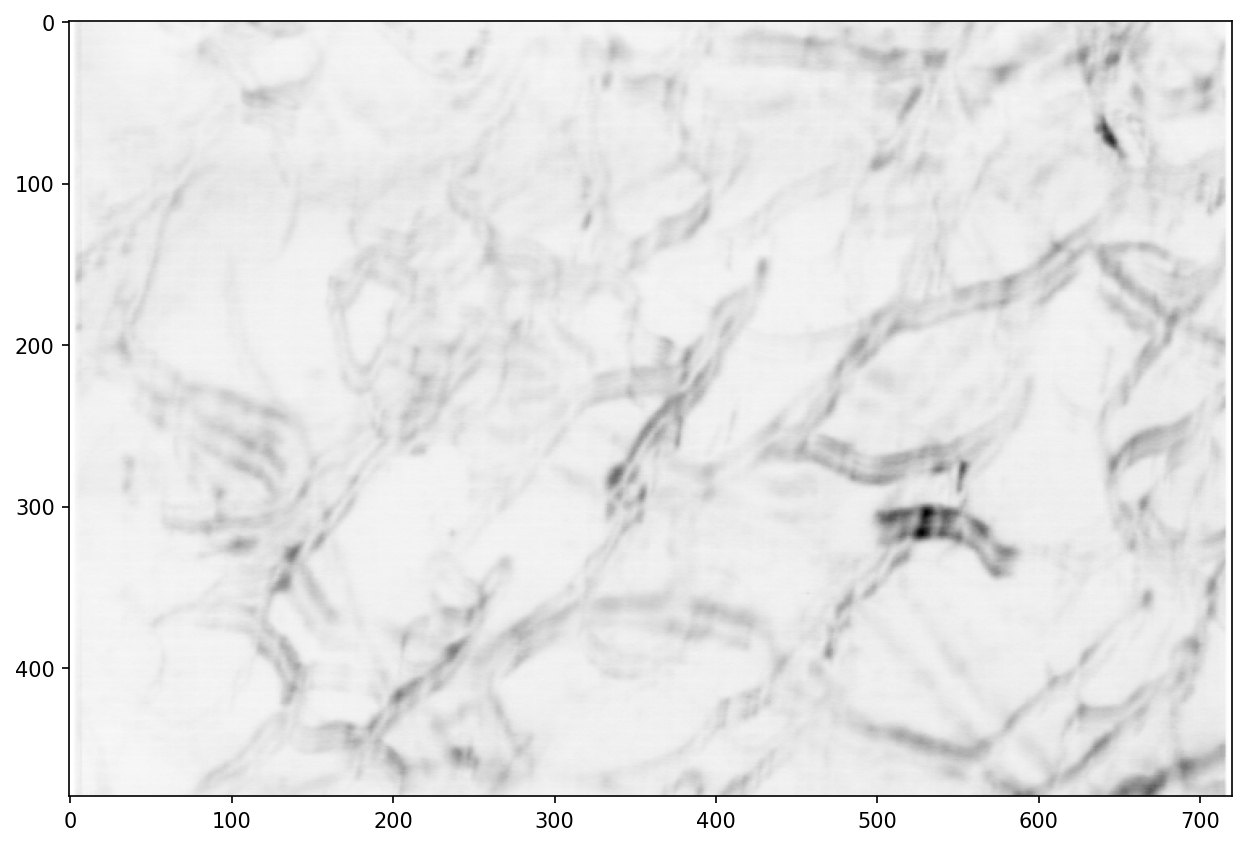

In [193]:
plot_frame(apfeatures[0][1][0][:,:,2])

# Merge data
Merge
* histmaps
* appearance features
* labels

In [118]:
%%time
data = pd.DataFrame()
for idx, ((fname1, histmap), (fname2, label), (fname3, (feats, feat_names))) in enumerate(zip(histmaps, labels, apfeatures)):
    assert(fname1 == fname2 and fname2 == fname3)
    df = pd.DataFrame(histmap.reshape(-1, histmap.shape[-1]), columns=['h'+str(i) for i in range(histmap.shape[-1])])
    df2 = pd.DataFrame(feats.numpy().reshape(-1, feats.shape[-1]), columns=['ap_'+ i for i in feat_names])
    df = pd.concat([df, df2], axis=1)
    df['label'] = label.flatten()
    df['id'] = idx
    data = data.append(df, ignore_index=True)

CPU times: user 51.1 s, sys: 46.4 s, total: 1min 37s
Wall time: 1min 37s


## Save to a file

In [119]:
# data.to_feather('pig52.feather')

# Load merged data

In [13]:
data = pd.read_feather('pig52.feather')

# Inspect MCBA 2.0 features

## visualize vessel detection at various threshold

In [ ]:
for (fname1, histmap), (fname2, label)in zip(histmaps, labels):    
    assert(fname1 == fname2)
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(10, 8), dpi=150)
    ax2.imshow(np.sum(histmap, axis=-1) > np.mean(np.sum(histmap, axis=-1)))
    ax2.set_title('Mean')
    ax2.set_axis_off()
    
    ax3.imshow(np.sum(histmap, axis=-1) > np.median(np.sum(histmap, axis=-1)))
    ax3.set_title('Median')
    ax3.set_axis_off()
    
    ax5.imshow(np.sum(histmap>0, axis=-1))
    ax5.set_title('Non zeros')
    ax5.set_axis_off()
    
    ax1.imshow(np.sum(histmap, axis=-1) > np.percentile(np.sum(histmap, axis=-1), 25))
    ax1.set_title('25%')
    ax1.text(0, 0, fname1) 
    ax1.set_axis_off()   
    
    ax4.imshow(np.sum(histmap, axis=-1) > np.percentile(np.sum(histmap, axis=-1), 75))
    ax4.set_title('75%')
    ax4.set_axis_off()   
    
    ax6.imshow(label)
    ax6.set_title('Annotation')
    ax6.set_axis_off()
#     fig.suptitle(fname1)

# Train binary classifiers to detect vessels

## A binary label indicating vessel or not
* vessel: label[i] > -2
* non-vessel: lebel[i] == -2

# Split data

In [226]:
%%time
test_id = 50
test_idx = data[data.id == test_id].index
train_idx = data[data.id != test_id].index
X_train, y_train = data.filter(regex='^h|(ap_var)').iloc[train_idx, :], (data.label > -2)[train_idx]
X_test, y_test = data.filter(regex='^h|(ap_var)').iloc[test_idx, :], (data.label > -2)[test_idx]

CPU times: user 10.3 s, sys: 17.2 s, total: 27.5 s
Wall time: 27.4 s


In [211]:
y_train.value_counts(normalize=True)

False    0.793523
True     0.206477
Name: label, dtype: float64

## Baseline
Use non zeros at each pixel

In [91]:
bin_data = data.filter(like='h').copy()
bin_data[bin_data > 0] = 1
bin_data = pd.concat([bin_data, data[['label', 'id']]], axis=1)

In [95]:
y_pred = bin_data.filter(like='h').any(axis=1)

In [ ]:
accuracy(data.label, y_pred)

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay

In [101]:
ConfusionMatrixDisplay(confusion_matrix(data.label, y_pred))

## RF

In [212]:
%%time
pipe = Pipeline([
    ('clf', RandomForestClassifier(max_samples=500, random_state=0, n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 1) Processing clf, total=  40.8s
CPU times: user 6min 3s, sys: 1min 53s, total: 7min 56s
Wall time: 40.8 s


Pipeline(steps=[('clf',
                 RandomForestClassifier(max_samples=500, n_jobs=-1,
                                        random_state=0))],
         verbose=True)

In [213]:
pipe.score(X_test, y_test)

0.8122916666666666

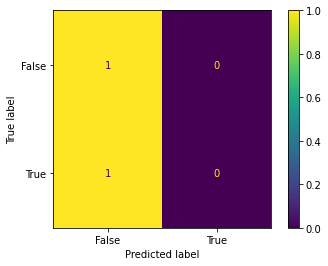

In [214]:
plot_confusion_matrix(pipe['clf'], X_test, y_test, normalize='true')

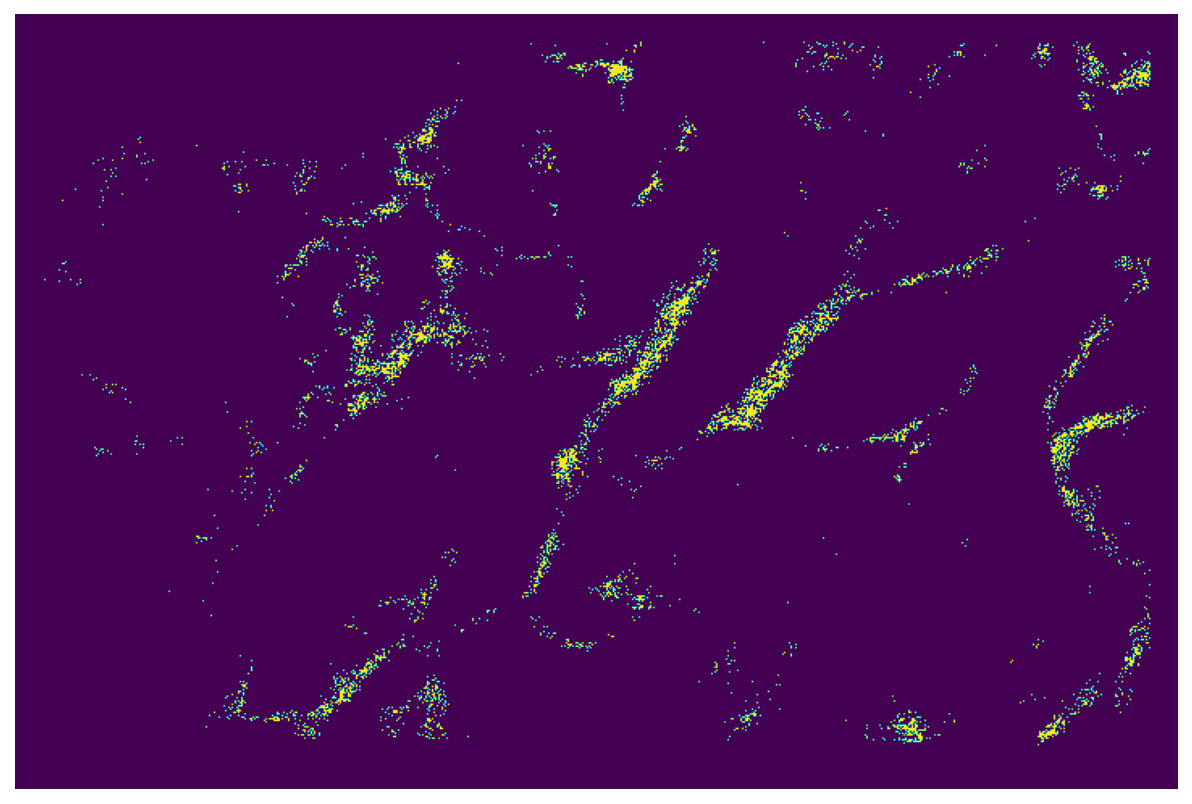

In [209]:
for name, group in data.groupby('id'):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), dpi=150)
    ax1.imshow(
        pipe['clf'].predict(
                group.filter(regex='^h|(ap_var)')
        ).reshape((480,720))
    )
    ax1.set_axis_off()
    break

## PCA + RF

In [126]:
%%time
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)), 
    ('clf', RandomForestClassifier(max_samples=5000, random_state=0, n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing pca, total=  33.6s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  31.1s
CPU times: user 10min 7s, sys: 1min 49s, total: 11min 56s
Wall time: 1min 4s


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('clf',
                 RandomForestClassifier(max_samples=5000, n_jobs=-1,
                                        random_state=0))],
         verbose=True)

In [127]:
pipe.score(X_test, y_test)

0.8005295138888889

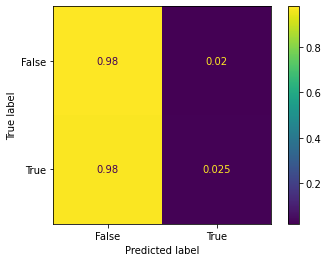

In [128]:
plot_confusion_matrix(pipe['clf'], pipe['pca'].transform(X_test), y_test, normalize='true')

## Downsample background instances

In [227]:
downsampled = resample(data[(data.id != test_id) & (data.label == -2)], replace=False, n_samples=len(data[(data.id != test_id) & (data.label > -2)]), random_state=27)

In [236]:
train = downsampled.append(data[(data.id != test_id) & (data.label > -2)])
X_train, y_train = train.filter(regex='^h|(ap_var)'), (train.label > -2)

In [237]:
y_train.value_counts(normalize=True)

True     0.5
False    0.5
Name: label, dtype: float64

## Now train RF on the balanced data

In [217]:
%%time
pipe = Pipeline([
    ('clf', RandomForestClassifier(max_samples=500, random_state=0, n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 1) Processing clf, total=  14.9s
CPU times: user 2min 4s, sys: 32.7 s, total: 2min 37s
Wall time: 14.9 s


Pipeline(steps=[('clf',
                 RandomForestClassifier(max_samples=500, n_jobs=-1,
                                        random_state=0))],
         verbose=True)

In [218]:
pipe.score(X_test, y_test)

0.3569965277777778

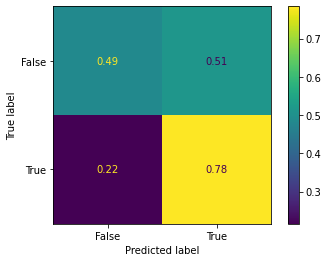

In [204]:
plot_confusion_matrix(pipe['clf'], X_test, y_test, normalize='true')

# Train LR on the balanced data

In [239]:
%%time
pipe = Pipeline([
    ('clf', LogisticRegression(random_state=0, solver='saga',penalty='l1', multi_class='ovr', n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 1) Processing clf, total=13.6min
CPU times: user 12min 36s, sys: 1min 3s, total: 13min 40s
Wall time: 13min 37s


Pipeline(steps=[('clf',
                 LogisticRegression(multi_class='ovr', n_jobs=-1, penalty='l1',
                                    random_state=0, solver='saga'))],
         verbose=True)

In [240]:
pipe.score(X_test, y_test)

0.44025462962962963

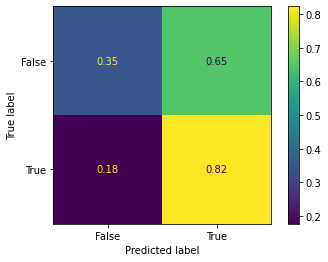

In [241]:
plot_confusion_matrix(pipe['clf'], X_test, y_test, normalize='true')

## Now train PCA + RF on the balanced data

In [133]:
%%time
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)), 
    ('clf', RandomForestClassifier(max_samples=5000, random_state=0, n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing pca, total=  13.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=  13.1s
CPU times: user 3min 34s, sys: 42.7 s, total: 4min 16s
Wall time: 27 s


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('clf',
                 RandomForestClassifier(max_samples=5000, n_jobs=-1,
                                        random_state=0))],
         verbose=True)

In [134]:
pipe.score(X_test, y_test)

0.3745515046296296

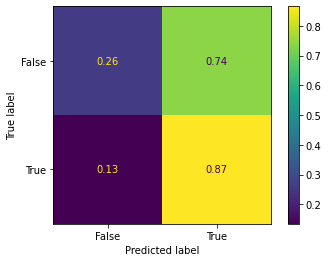

In [135]:
plot_confusion_matrix(pipe['clf'], pipe['pca'].transform(X_test), y_test, normalize='true')

In [133]:
pipe.score(X_test, y_test)

0.6176793981481481

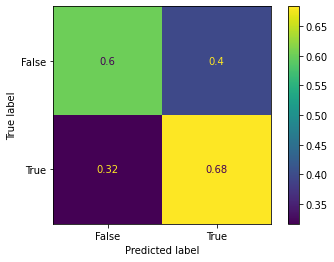

In [134]:
plot_confusion_matrix(pipe['clf'], pipe['pca'].transform(X_test), y_test, normalize='true')

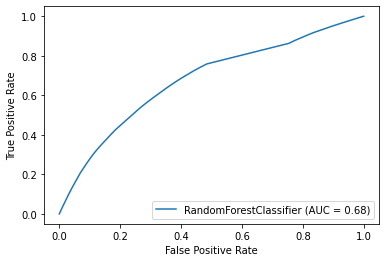

In [135]:
plot_roc_curve(pipe['clf'], pipe['pca'].transform(X_test), y_test)

### Plot vessel detection prediction

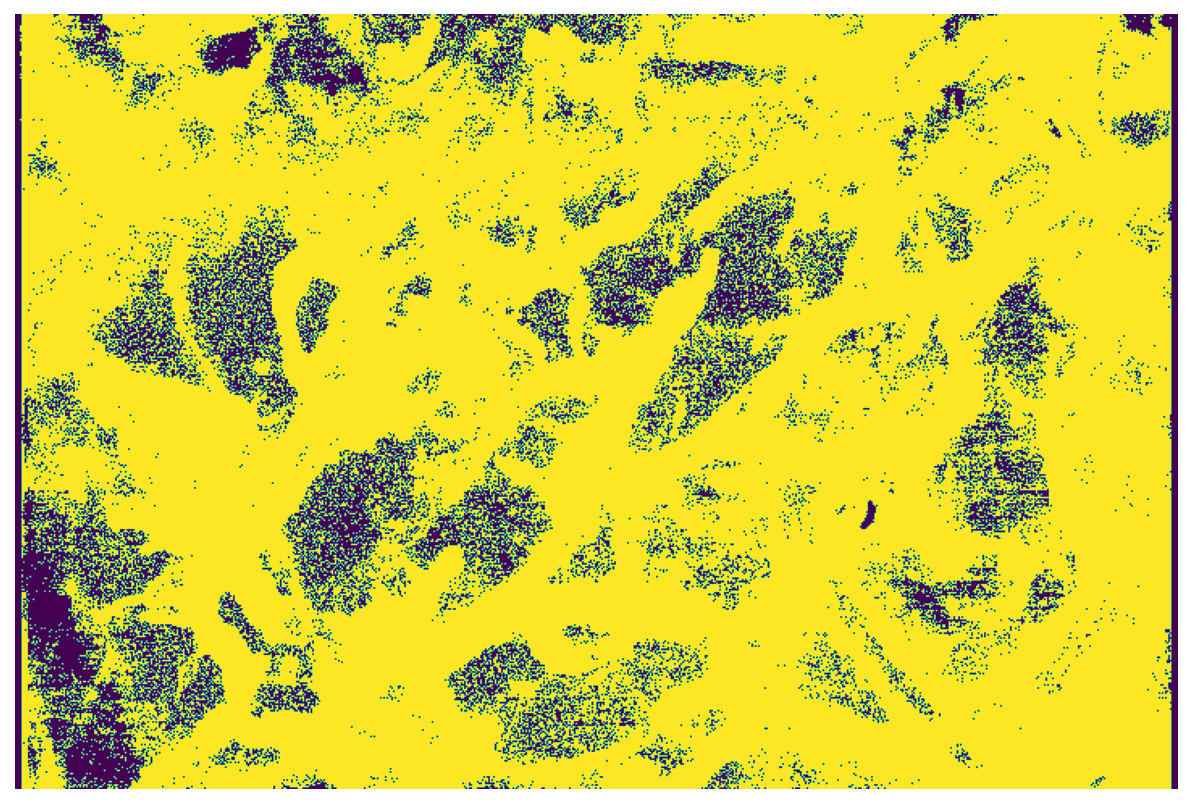

In [137]:
for name, group in data.groupby('id'):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), dpi=150)
    ax1.imshow(
        pipe['clf'].predict(
            pipe['pca'].transform(
                group.filter(regex='^h|(ap_)')
            )
        ).reshape((480,720))
    )
    ax1.set_axis_off()
    break

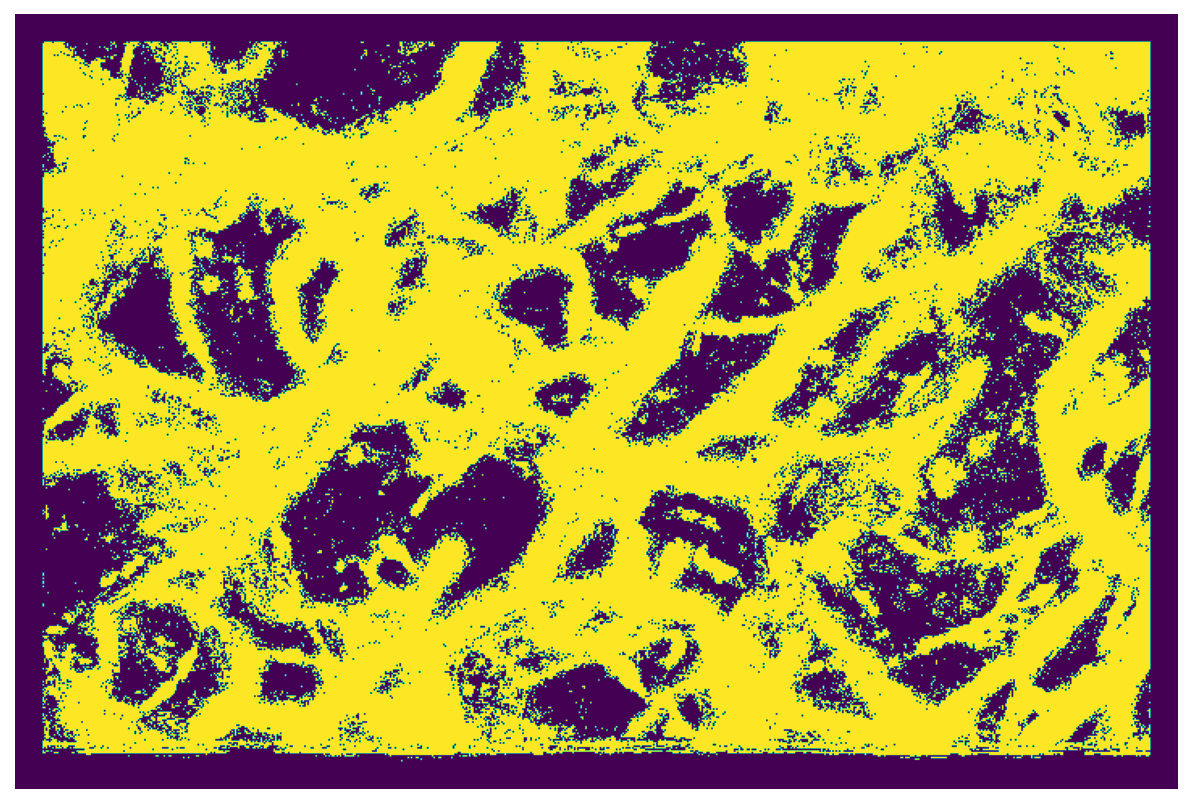

In [148]:
for name, group in data.groupby('id'):
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 8), dpi=150)
    ax1.imshow(
        pipe['clf'].predict(
            pipe['pca'].transform(
                group.filter(like='h')
            )
        ).reshape((480,720))
    )
    ax1.set_axis_off()
    break

## Try KNN

## Try PCA + LR

In [58]:
%%time
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)), 
    ('clf', LogisticRegression(random_state=0, n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing pca, total=  14.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 2.1min
CPU times: user 1min 19s, sys: 17.2 s, total: 1min 36s
Wall time: 2min 21s


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('clf', LogisticRegression(n_jobs=-1, random_state=0))],
         verbose=True)

In [59]:
pipe.score(X_test, y_test)

0.7862008101851852

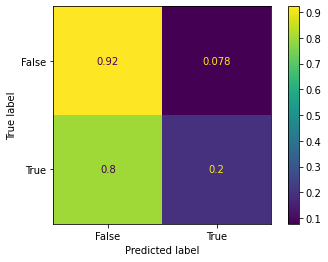

In [64]:
plot_confusion_matrix(pipe['clf'], pipe['pca'].transform(X_test), y_test, normalize='true')

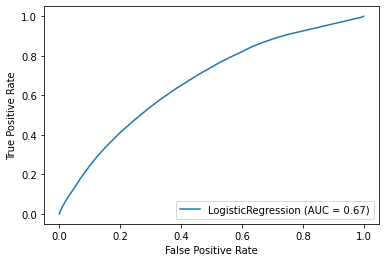

In [65]:
plot_roc_curve(pipe['clf'], pipe['pca'].transform(X_test), y_test)

# Compare model performance on the vessel detection
* Binary classification
* Per pixel
* Models
    * AVA (centerline + wall)
    * MCBA 1.0 (centerline only)
    * MCBA 2.0 (centerline + wall)
* Metrics
    * f1
    * accuracy

In [139]:
from sklearn.metrics import accuracy_score

In [202]:
def metrics(labels, data_ava, mcba_old, histmaps):
    df = pd.DataFrame(columns=['vid', 'model', 'metric', 'score'])
    for (name, label), (_, ava), (_, old), (_, new) in zip(labels, data_ava, mcba_old, histmaps):
        label, ava, old, new = np.copy(label).flatten(), np.copy(ava).flatten(), np.copy(old).flatten(), np.copy(new)
        label[label > -2] = 1
        label[label <= -2] = 0
        ava[ava > -2] = 1
        ava[ava <= -2] = 0
        old[old > 0] = 1
        h = np.sum(new>0, axis=-1)
        threshold=h.mean()
        h[h<=threshold] = 0
        h[h>threshold] = 1
        h = h.flatten()

        assert(label.shape == h.shape)

        def add_model(model, yhat):
            return (
                df.append(dict(vid=name, model=model, metric='accuracy', score=accuracy_score(label, yhat)), ignore_index=True)
                .append(dict(vid=name, model=model, metric='f1', score=f1_score(label, yhat)), ignore_index=True)
            )

        df = add_model('ava', ava)
        df = add_model('old', old)
        df = add_model('new', h)
    return df

In [204]:
%%time
df = metrics(labels, data_ava, mcba_old, histmaps)

CPU times: user 28.3 s, sys: 1.46 s, total: 29.7 s
Wall time: 29.7 s


## Scores for each video

In [206]:
pd.pivot_table(df, values='score', index=['vid', 'model'], columns='metric')

metric                                                   accuracy        f1
vid                                               model                    
PIG-UPMC-pig44001-T0-hgomez-2013-01-15-10-03-37-1 ava    0.795217  0.334809
                                                  new    0.610778  0.404387
                                                  old    0.818070  0.324339
PIG-UPMC-pig44001-T0-hgomez-2013-01-15-10-28-50-2 ava    0.790952  0.341551
                                                  new    0.654444  0.430381
...                                                           ...       ...
PIG-UPMC-pig61003-T0-hgomez-2013-06-06-15-28-23-0 new    0.716386  0.453253
                                                  old    0.782115  0.277764
PIG-UPMC-pig63001-T0-hgomez-2013-06-10-10-41-56-3 ava    0.750796  0.183935
                                                  new    0.671965  0.409644
                                                  old    0.746600  0.175803

[153 rows x 2 columns]

## Mean score across all videos

In [207]:
pd.pivot_table(df, index=['model'], values='score', columns='metric')

metric,accuracy,f1
model,,
ava,0.761078,0.300992
new,0.674658,0.427951
old,0.789773,0.277444


# Visualize the model prediction per video

In [ ]:
assert(len(histmaps) == len(labels))
for (fname1, histmap), (fname2, label), (fname3, ava), (fname4, old) in zip(histmaps, labels, data_ava, mcba_old):    
    assert(fname1 == fname2)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 8), dpi=150)
    ax1.imshow(ava)
    ax1.set_title('AVA')
    ax1.text(0, 0, fname1)
    ax1.set_axis_off()
    ax2.imshow(old)
    ax2.set_title('MCBA old')
    ax2.set_axis_off()
    ax3.imshow(np.sum(histmap>0, axis=-1))
    ax3.set_title('MCBA new')
    ax3.set_axis_off()
    ax4.imshow(label)
    ax4.set_title('Annotation')
    ax4.set_axis_off()
#     fig.suptitle(fname1)

# Split data

In [14]:
%%time
test_id = 50
test_idx = data[(data.id == test_id) & (data.label >= 0)].index
train_idx = data[(data.id != test_id)  & (data.label >= 0)].index
X_train, y_train = data.iloc[train_idx, 0:100], data.iloc[train_idx, 100]
X_test, y_test = data.iloc[test_idx, 0:100], data.iloc[test_idx, 100]

CPU times: user 2.85 s, sys: 940 ms, total: 3.79 s
Wall time: 3.79 s


In [141]:
X_train.shape

(3500503, 100)

In [143]:
X_test.shape

(64872, 100)

In [184]:
y_train.value_counts(normalize=True)

3.0    0.748081
2.0    0.090642
0.0    0.087069
1.0    0.059700
4.0    0.014508
Name: label, dtype: float64

# Random forest classifier

In [146]:
from sklearn.ensemble import RandomForestClassifier

In [219]:
%%time
clf = RandomForestClassifier(max_samples=5000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 1min 25s, sys: 6.17 s, total: 1min 31s
Wall time: 7.29 s


RandomForestClassifier(max_samples=5000, n_jobs=-1, random_state=0)

In [220]:
clf.score(X_test, y_test)

0.7059131828832161

In [221]:
y_pred = clf.predict(X_test)

In [224]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, f1_score

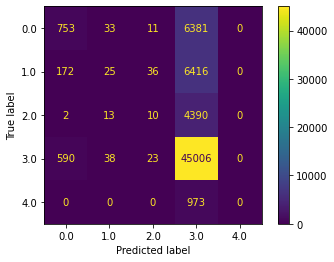

In [222]:
plot_confusion_matrix(clf, X_test, y_test)

In [228]:
f1_score(y_test, y_pred, average='micro')

0.7059131828832161

# Pipelines with dimension reduction

In [9]:
%%time
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)), 
    ('clf', RandomForestClassifier(max_samples=5000, random_state=0, n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing pca, total=   6.7s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   6.6s
CPU times: user 1min 57s, sys: 15.2 s, total: 2min 12s
Wall time: 13.4 s


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('clf',
                 RandomForestClassifier(max_samples=5000, n_jobs=-1,
                                        random_state=0))],
         verbose=True)

In [12]:
print('Number of compoents: {}'.format(pipe['pca'].n_components_))

Number of compoents: 12


In [10]:
pipe.score(X_test, y_test)

0.7038475767665556

## PCA + LR

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)), 
    ('clf', LogisticRegression(random_state=0, n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing pca, total=   6.8s
[Pipeline] ............... (step 2 of 2) Processing clf, total= 3.3min


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('clf', LogisticRegression(n_jobs=-1, random_state=0))],
         verbose=True)

In [7]:
pipe.score(X_test, y_test)

0.7037859168824763

In [8]:
from sklearn.naive_bayes import GaussianNB

In [9]:
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)), 
    ('clf', GaussianNB())
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing pca, total=   6.5s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   0.8s


Pipeline(steps=[('pca', PCA(n_components=0.95)), ('clf', GaussianNB())],
         verbose=True)

In [10]:
pipe.score(X_test, y_test)

0.6923942532988038

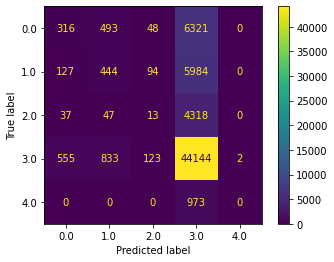

In [13]:
plot_confusion_matrix(pipe['clf'], pipe['pca'].transform(X_test), y_test)

# One vs all classifier

In [168]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

In [163]:
n_classes = len(y_test.unique())

In [173]:
%%time
clf = OneVsRestClassifier(RandomForestClassifier(max_samples=5000, random_state=0, n_jobs=-1), n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 1.05 s, sys: 1.15 s, total: 2.2 s
Wall time: 22.8 s


OneVsRestClassifier(estimator=RandomForestClassifier(max_samples=5000,
                                                     n_jobs=-1,
                                                     random_state=0),
                    n_jobs=-1)

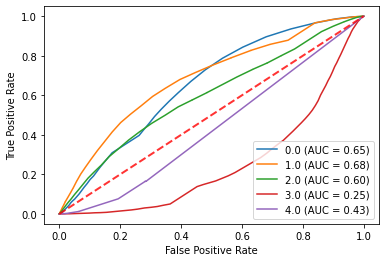

In [189]:
ax = plt.subplot()
for estimator, label in zip(clf.estimators_, clf.classes_):
    plot_roc_curve(estimator, X_test, y_test, name=label, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Resample
1. Downsample class=3
1. Upsample class=4
    1. adding noise

In [117]:
from sklearn.utils import resample

In [118]:
n_samples = data[(data.id != test_id)  & (data.label == 0)].shape[0]

In [119]:
def upsample(label):
    to_upsample_idx = data[(data.id != test_id)  & (data.label == label)].index
    return resample(data.iloc[to_upsample_idx, :], replace=True, n_samples=n_samples, random_state=27)

In [120]:
upsampled_4 = upsample(4)
upsampled_1 = upsample(1)

In [121]:
to_downsample_idx = data[(data.id != test_id)  & (data.label == 3)].index
downsampled = resample(data.iloc[to_downsample_idx, :], replace=False, n_samples=n_samples, random_state=27)

In [122]:
bal_idx = data[(data.id != test_id)  & (data.label.isin([0, 2]))].index
train_bal = data.iloc[bal_idx, :]
for sampled in [upsampled_1, upsampled_4, downsampled]:
    train_bal = train_bal.append(sampled)
train_bal = train_bal.reset_index(drop=True)

In [123]:
# Generate training data from the balanced data
X_train, y_train = train_bal.iloc[:, 0:100], train_bal.iloc[:, 100]

In [124]:
y_train.value_counts(normalize=True)

2.0    0.206513
1.0    0.198372
4.0    0.198372
3.0    0.198372
0.0    0.198372
Name: label, dtype: float64

# Pipelines with dimension reduction

In [125]:
%%time
pipe = Pipeline([
    ('pca', PCA(n_components=0.95)), 
    ('clf', RandomForestClassifier(max_samples=5000, random_state=0, n_jobs=-1))
], verbose=True)
pipe.fit(X_train, y_train)

[Pipeline] ............... (step 1 of 2) Processing pca, total=   2.9s
[Pipeline] ............... (step 2 of 2) Processing clf, total=   3.3s
CPU times: user 46.4 s, sys: 6.18 s, total: 52.5 s
Wall time: 6.22 s


Pipeline(steps=[('pca', PCA(n_components=0.95)),
                ('clf',
                 RandomForestClassifier(max_samples=5000, n_jobs=-1,
                                        random_state=0))],
         verbose=True)

In [126]:
print('Number of compoents: {}'.format(pipe['pca'].n_components_))

Number of compoents: 11


In [127]:
pipe.score(X_test, y_test)

0.4040451388888889

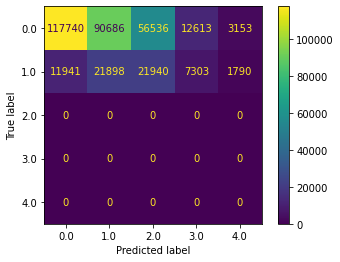

In [128]:
plot_confusion_matrix(pipe['clf'], pipe['pca'].transform(X_test), y_test)

# Fit on balanced data

In [214]:
%%time
clf = OneVsRestClassifier(RandomForestClassifier(max_samples=5000, random_state=0, n_jobs=-1), n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 694 ms, sys: 2.74 s, total: 3.43 s
Wall time: 12.7 s


OneVsRestClassifier(estimator=RandomForestClassifier(max_samples=5000,
                                                     n_jobs=-1,
                                                     random_state=0),
                    n_jobs=-1)

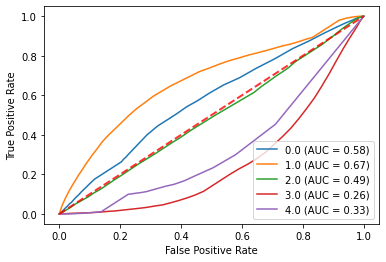

In [215]:
ax = plt.subplot()
for estimator, label in zip(clf.estimators_, clf.classes_):
    plot_roc_curve(estimator, X_test, y_test, name=label, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Cross Validation